In [108]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

### Split X and Y into two dataframes 

Split input variables from output variable (temperature)

In [109]:
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

In [110]:
x_train = train.drop(['average_temperature_°c'], axis=1)
x_val = val.drop(['average_temperature_°c'], axis=1)
x_test = test.drop(['average_temperature_°c'], axis=1)

Y_train = pd.DataFrame(train['average_temperature_°c'])
Y_val = pd.DataFrame(val['average_temperature_°c'])
Y_test = pd.DataFrame(test['average_temperature_°c'])

In [111]:
print(x_train.shape)
print(Y_train.shape)

print(x_val.shape)
print(Y_val.shape)

print(x_test.shape)
print(Y_test.shape)

(4681, 47)
(4681, 1)
(570, 47)
(570, 1)
(570, 47)
(570, 1)


In [132]:
def show_history(history):
  plt.plot(history.history['loss'], color='black', label='train')
  plt.plot(history.history['val_loss'], color='red', label='val')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print('final train mae: %.3f' %history.history['loss'][-1])
  print('final val mae:   %.3f' %history.history['val_loss'][-1])
  print('final train rmse: %.3f' %history.history['root_mean_squared_error'][-1])
  print('final train rmse: %.3f' %history.history['val_root_mean_squared_error'][-1])

### Model 1: Baseline Model - Linear Regression SGD

</br> Input - Total Emissions
</br>Output - Avg Temp
</br>Loss - Mean Absolute Error
</br>Metrics - Root Mean Squared Error

In [123]:
def build_model_1():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(tot_em)

  model = tf.keras.Model(inputs=[tot_em],
                         outputs=temp,
                         name='Model_1')
  model.compile(
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Total Emissions (InputLaye  [(None, 1)]               0         
 r)                                                              
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


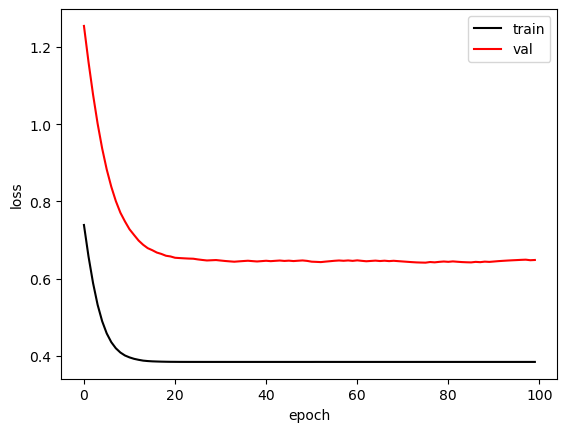

final train mae: 0.385
final val mae:   0.649
final train rmse: 0.506
final train rmse: 0.747


In [133]:
model_1 = build_model_1()
model_1.summary()

history = model_1.fit(
  x=x_train[['total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=100,
  batch_size=40,
  validation_data=(
      x_val[['total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history)

### Model 2: Linear Regression (Adam)

</br> Input - Total Emissions
</br>Output - Avg Temp
</br> Requires fewer epochs to converge than standard SGD regression

In [71]:
def build_model_2():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(tot_em)

  model = tf.keras.Model(inputs=[tot_em],
                         outputs=temp,
                         name='Model_2')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Total Emissions (InputLaye  [(None, 1)]               0         
 r)                                                              
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


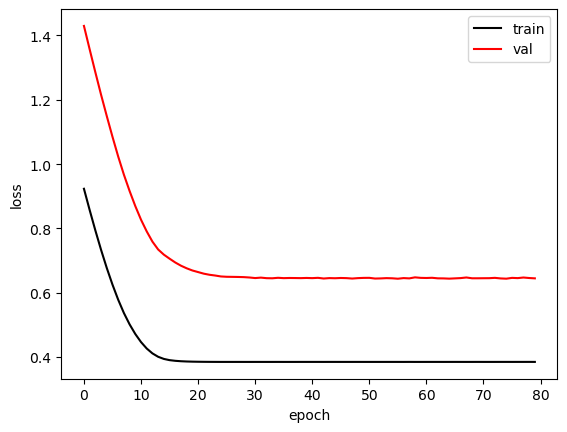

final train mae: 0.385
final val mae:   0.645


In [73]:
model_2 = build_model_2()
model_2.summary()

history = model_2.fit(
  x=x_train[['total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=80,
  validation_data=(
      x_val[['total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history)

### Model 3: Linear Regression (Adam) using Cumulative Sum of Total Emissions

</br> Input - Cumulative Sum of Total Emissions
</br>Output - Avg Temp
</br> Very little difference to Model 2

In [76]:
def build_model_3():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  cum_sum_tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Cum Sum Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(cum_sum_tot_em)

  model = tf.keras.Model(inputs=[cum_sum_tot_em],
                         outputs=temp,
                         name='Model_3')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Cum Sum Total Emissions (I  [(None, 1)]               0         
 nputLayer)                                                      
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


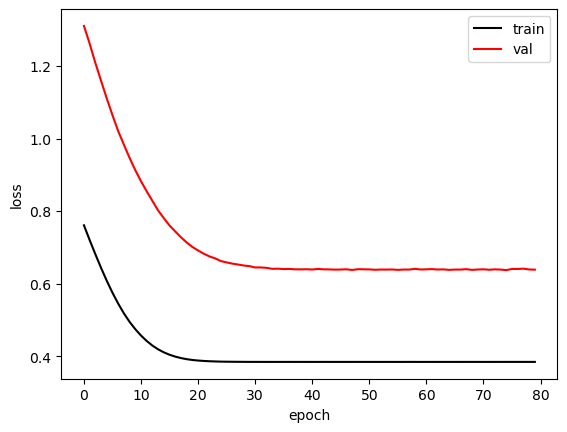

final train mae: 0.384
final val mae:   0.639


In [78]:
model_3 = build_model_3()
model_3.summary()

history = model_3.fit(
  x=x_train[['cum_sum_total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=100,
  validation_data=(
      x_val[['cum_sum_total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history)

### Model 4: Linear Regression (Adam) using Cumulative Sum of Total Emissions & Urban Pop

</br> Input - Cumulative Sum of Total Emissions & Urban Population
</br>Output - Avg Temp
</br> Very little difference to model 3

In [81]:
def build_model_4():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  cum_sum_tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Cum Sum Total Emissions')
  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')

  features = tf.keras.layers.Concatenate()([cum_sum_tot_em, urban_pop])

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[cum_sum_tot_em, urban_pop],
                         outputs=temp,
                         name='Model_4')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Cum Sum Total Emissions (I  [(None, 1)]                  0         []                            
 nputLayer)                                                                                       
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 concatenate (Concatenate)   (None, 2)                    0         ['Cum Sum Total Emissions[0][0
                                                                    ]',                     

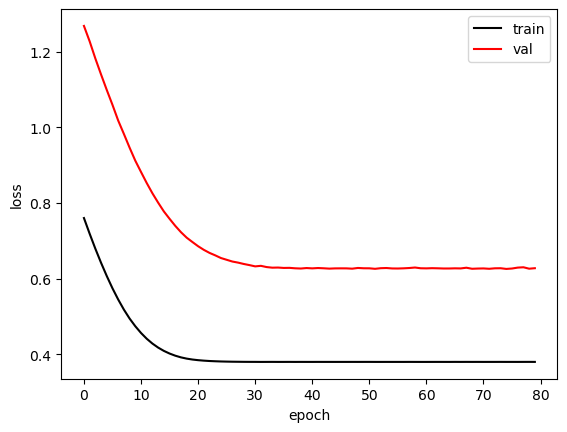

final train mae: 0.380
final val mae:   0.628


In [82]:
model_4 = build_model_4()
model_4.summary()

history = model_4.fit(
  x={
      'Cum Sum Total Emissions': x_train[['cum_sum_total_emission']],
      'Urban Population': x_train[['log_urban_population']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=100,
  validation_data=(
      {
      'Cum Sum Total Emissions': x_val[['cum_sum_total_emission']],
      'Urban Population': x_val[['log_urban_population']]
    },
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history)

### Model 5: Linear Regression (Adam) Kitchen Sink 

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>Still some noise in validation loss, but shape of loss curves look good and training loss is less than val loss. Could maybe use a few more epochs for convergence. 

In [96]:
def build_model_5():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia', 'Central Asia'], 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id])
    
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region],
                         outputs=temp,
                         name='Model_5')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

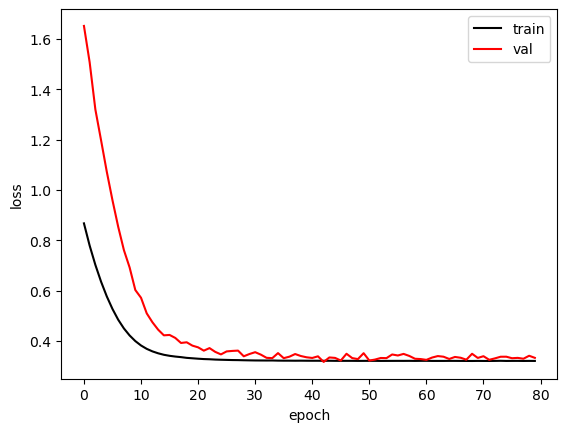

final train mae: 0.320
final val mae:   0.333


In [97]:
model_5 = build_model_5()
model_5.summary()

history = model_5.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=100,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

#### Model 6 - Linear Regression (Adam) Kitchen Sink (Hyperparameter Tuning)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>Added exponential decay learning rate scheduler. Increased epochs and batch size to 300 to try to reduce noise. Small amount of overfitting to training data which is prefereable. Less noise in validation loss. 

In [103]:
def build_model_6():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia','Central Asia'], 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id])
    
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region],
                         outputs=temp,
                         name='Model_6')
  
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

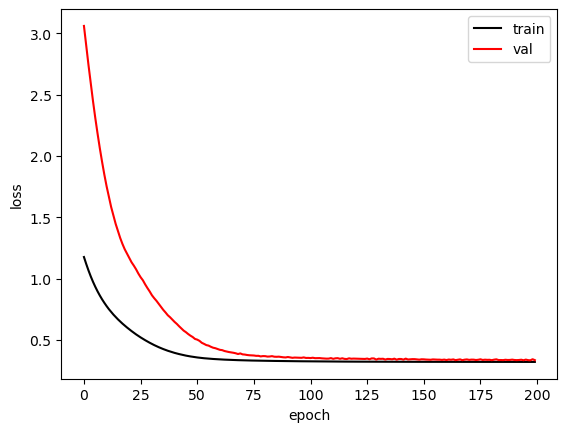

final train mae: 0.321
final val mae:   0.335


In [106]:
model_6 = build_model_6()
model_6.summary()

history = model_6.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=200,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

### Model 7: FFNN (1 Hidden Layer)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>1 Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [116]:
def build_model_7():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia', 'Central Asia'], 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_1)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region],
                         outputs=temp,
                         name='Model_7')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

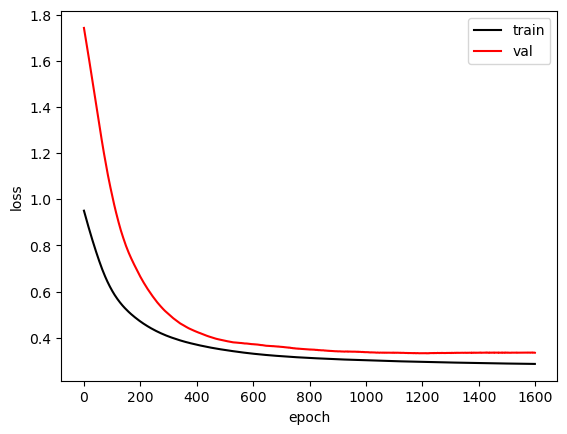

final train mae: 0.286
final val mae:   0.334


In [119]:
model_7 = build_model_7()
model_7.summary()

history = model_7.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=1600,
  batch_size=600,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

### Model 8: FFNN (2 Hidden Layers)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>1st Hidden Layer Size: 128
</br>2nd Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [120]:
def build_model_8():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  # region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia','Central Asia'], 
                                               output_mode='one_hot')(sub_region)

  # region_id = tf.keras.layers.StringLookup(vocabulary=['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'], 
  #                                              output_mode='one_hot')(region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id
                                            # , region_id
                                           ])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)

  hidden_2 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_2')(hidden_1)

  # dropout_1 = tf.keras.layers.Dropout(0.1, name='Dropout_1')(hidden_2)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_2)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region
                                            # , region
                                            ],
                         outputs=temp,
                         name='Model_8')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

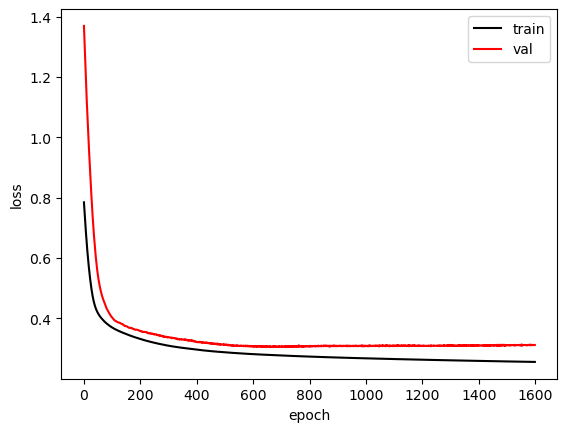

final train mae: 0.256
final val mae:   0.312


In [122]:
model_8 = build_model_8()
model_8.summary()

history = model_8.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
      # ,
      # 'Region': x_train[['region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=1600,
  batch_size=500,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      #     ,
      # 'Region': x_val[['region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

### Model 9: FFNN (3 Hidden Layers)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>1st Hidden Layer Size: 128
</br>2nd Hidden Layer Size: 128
</br>3rd Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [131]:
def build_model_9():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  # region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia','Central Asia'], 
                                               output_mode='one_hot')(sub_region)

  # region_id = tf.keras.layers.StringLookup(vocabulary=['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'], 
  #                                              output_mode='one_hot')(region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id
                                            # , region_id
                                           ])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)

  hidden_2 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_2')(hidden_1)

  hidden_3 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_3')(hidden_2)

  # dropout_1 = tf.keras.layers.Dropout(0.1, name='Dropout_1')(hidden_2)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_3)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region
                                            # , region
                                            ],
                         outputs=temp,
                         name='Model_9')
  
  initial_learning_rate = 0.000001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

Model: "Model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

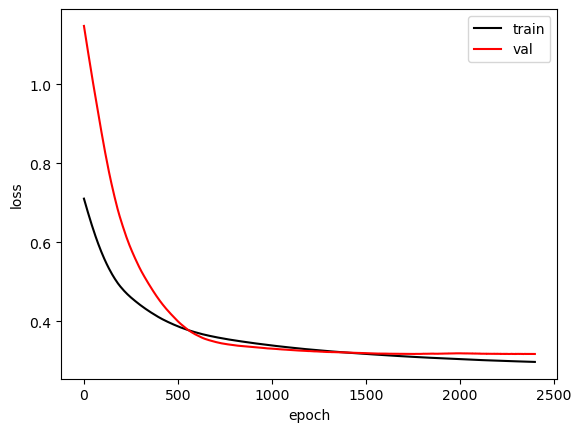

final train mae: 0.297
final val mae:   0.317


In [133]:
model_9 = build_model_9()
model_9.summary()

history = model_9.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
      # ,
      # 'Region': x_train[['region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=2400,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      #     ,
      # 'Region': x_val[['region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

### Model 10: LSTM (Long Short Term Memory)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [6]:
def build_model_10():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  # region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=['Southern Asia', 'Southern Europe', 
                                                           'Northern Africa', 'Polynesia',
                                                           'Sub-Saharan Africa', 'Latin America and the Caribbean',
                                                           'Australia and New Zealand', 'Western Europe', 
                                                           'Western Asia','Northern America', 'South-eastern Asia', 
                                                           'Eastern Europe','Northern Europe', 'Eastern Asia', 
                                                           'Melanesia','Micronesia','Central Asia'], 
                                               output_mode='one_hot')(sub_region)

  # region_id = tf.keras.layers.StringLookup(vocabulary=['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'], 
  #                                              output_mode='one_hot')(region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id
                                            # , region_id
                                           ])
  
  lstm_layer = tf.keras.layers.LSTM(
        units=200,
        input_shape=(None,30),
        #recurrent_dropout=0.4,
        #use_bias=True,
        return_sequences=True,
        name='LSTM')(features)   

  # dropout_1 = tf.keras.layers.Dropout(0.1, name='Dropout_1')(hidden_2)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(lstm_layer)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region
                                            # , region
                                            ],
                         outputs=temp,
                         name='Model_10')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError()
      )

  return model

In [7]:
model_10 = build_model_10()
model_10.summary()

history = model_10.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
      # ,
      # 'Region': x_train[['region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=2000,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      #     ,
      # 'Region': x_val[['region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history)

ValueError: Input 0 of layer "LSTM" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 30)

In [16]:
def build_lstm_model(len_features):
    """
    Return a simple Keras model with a single LSTM layer, dropout later, 
    and then dense prediction layer.
    
    Args:
    lstm_hidden_units (int): units in the LSTM layer    
    
    Returns:
    model_lstm (tf.keras.Model) LSTM keras model with output dimension (None,1)
    """
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
    model_lstm = None
    
    # instanntiate model
    model_lstm = tf.keras.Sequential()
    
    # add layers
    model_lstm.add(LSTM(
        units=200,
        #recurrent_dropout=0.4,
        #use_bias=True,
        return_sequences=True,
        name='LSTM1'))    
    
    # model_lstm.add(Dropout(
    #     rate=0.5,
    #     name='Dropout1'
    # ))
    
    # add layers
    model_lstm.add(Dense(
        units=64,
        activation='relu',
        name='Dense1'
    ))
    
    
    model_lstm.add(Dense(
        units=1,
        activation=None,
        name='Output'))
    
    model_lstm.build(input_shape=(None, None, len_features))

    
    model_lstm.summary()

    # END CODE #
    return model_lstm

In [20]:
features = ['urban_population',
            'mei',
            'cum_sum_log_crop_residues',
            'cum_sum_log_rice_cultivation',
            'cum_sum_log_drained_organic_soils_co2',
            'cum_sum_log_net_forest_conversion',
            'cum_sum_log_fires',
            'cum_sum_log_manure_mgmt',
            'cum_sum_log_food_systems',
            'cum_sum_log_ippu_tot',
            'cum_sum_log_on_farm_energy_use',
            'cum_sum_forestland']
# features_len = len(features)
model_lstm = build_lstm_model(12)
output = model_lstm(x_train[features])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, None, 200)         170400    
                                                                 
 Dense1 (Dense)              (None, None, 64)          12864     
                                                                 
 Output (Dense)              (None, None, 1)           65        
                                                                 
Total params: 183329 (716.13 KB)
Trainable params: 183329 (716.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ValueError: Exception encountered when calling layer 'sequential' (type Sequential).

Input 0 of layer "LSTM1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (4681, 12)

Call arguments received by layer 'sequential' (type Sequential):
  • inputs=      urban_population       mei  cum_sum_log_crop_residues  \
0            -0.248427  0.200000                  -0.991443   
1            -0.270189  0.200000                  -1.017058   
2            -0.078775  0.200000                  -0.996081   
3            -0.287987  0.200000                  -0.974624   
4            -0.218440  0.200000                  -1.029345   
...                ...       ...                        ...   
4676          0.132811 -0.041667                   1.529675   
4677          0.188093 -0.041667                   2.875583   
4678         -0.149257 -0.041667                   1.056772   
4679         -0.188201 -0.041667                   1.194054   
4680         -0.210840 -0.041667                   1.377258   

      cum_sum_log_rice_cultivation  cum_sum_log_drained_organic_soils_co2  \
0                        -1.240624                              -0.726651   
1                        -1.302695                              -0.650712   
2                        -1.331181                              -0.726651   
3                        -1.235037                              -0.726651   
4                        -1.301800                              -0.632413   
...                            ...                                    ...   
4676                      1.952466                               2.074905   
4677                      3.517855                               2.608154   
4678                      1.497505                              -0.726651   
4679                      0.215489                               3.131391   
4680                     -0.987684                              -0.726651   

      cum_sum_log_net_forest_conversion  cum_sum_log_fires  \
0                             -0.863273          -0.803507   
1                             -0.863273          -0.806118   
2                             -0.772093          -0.764806   
3                             -0.863273          -0.851537   
4                             -0.734895          -0.661346   
...                                 ...                ...   
4676                           3.187469           2.565849   
4677                          -0.408619           2.375457   
4678                          -0.863273          -0.847428   
4679                           2.089902           3.812554   
4680                           2.374310           2.532260   

      cum_sum_log_manure_mgmt  cum_sum_log_food_systems  cum_sum_log_ippu_tot  \
0                   -1.341128                 -1.518110             -1.579650   
1                   -1.353112                 -1.528564             -1.554559   
2                   -1.337138                 -1.481105             -1.529818   
3                   -1.325553                 -1.530632             -1.547863   
4                   -1.344838                 -1.512544             -1.565645   
...                       ...                       ...                   ...   
4676                 2.276407                  2.147967              2.156889   
4677                 2.318830                  2.233055              1.978469   
4678                 1.739324                  1.746810              1.324681   
4679                 1.598514                  1.362552              1.201612   
4680                 1.861136                  1.314864              1.356778   

      cum_sum_log_on_farm_energy_use  cum_sum_forestland  
0                          -1.217366            0.228626  
1                          -1.275860            0.230803  
2                          -1.293127            0.230641  
3                          -1.304697            0.230739  
4                          -1.320237            0.230739  
...                              ...                 ...  
4676                        1.504083            0.262554  
4677                        2.019110           -0.522192  
4678                        2.011003            0.230739  
4679                        0.423696            0.230739  
4680                        2.133962            0.232733  

[4681 rows x 12 columns]
  • training=None
  • mask=None

In [93]:
x_train_temp = x_train.sort_values(['area','year']).reset_index(drop=True)
x_train_temp.shape

(4681, 38)

In [57]:
agg_x_train = x_train_temp.groupby('area').sum()
agg_x_train.head()

,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,fires,manure_mgmt,...,cum_sum_log_rice_cultivation,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,cum_sum_total_emission
area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,50050,-5.236087,-2.583333,-4.472989,-5.006783,-6.031209,5.804088,-4.553359,-4.041900,-4.796264,...,5.205943,-18.166267,-21.581831,-5.627949,6.059289,-2.768944,-13.653029,22.084143,5.311765,-6.644269
Albania,50050,-6.685379,-2.583333,-6.416871,-5.641232,-5.865593,5.929604,-4.553359,-4.044939,-7.286005,...,-11.170218,6.509985,-21.581831,-7.855573,1.513338,-6.899834,-4.501250,-3.207665,5.670532,-6.687033
Algeria,50050,0.546039,-2.583333,-4.801637,-5.897087,-6.031209,5.770650,-4.477398,-3.929318,-4.636482,...,-25.453132,-18.166267,-0.736706,6.451740,6.476133,9.672907,3.962128,-3.250784,5.536773,-3.847180
Andorra,50050,-7.194387,-2.583333,-4.386533,-4.694164,-6.031209,6.110523,-4.553359,-4.057493,-4.123842,...,7.297943,-18.166267,-21.581831,-21.288424,7.713736,-12.695721,-2.961787,-8.382151,5.768470,-6.519540
Angola,50050,-3.406520,-2.583333,-6.099968,-5.771773,-5.519872,6.110523,0.727967,44.336883,-5.774811,...,-9.674036,12.412896,22.007167,40.501281,4.427459,-0.986452,-7.731921,-9.891681,5.768470,1.654339


In [71]:
agg_x_train = agg_x_train[agg_x_train['year'] != 50050]
agg_x_train.index


Index(['Armenia', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Croatia', 'Czechia', 'Eritrea', 'Estonia', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Marshall Islands',
       'Micronesia (Federated States of)', 'North Macedonia',
       'Republic of Moldova', 'Russian Federation', 'Slovakia', 'Slovenia',
       'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan'],
      dtype='object', name='area')

In [94]:
countries = ['Armenia', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Croatia', 'Czechia', 'Eritrea', 'Estonia', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Marshall Islands',
       'Micronesia (Federated States of)', 'North Macedonia',
       'Republic of Moldova', 'Russian Federation', 'Slovakia', 'Slovenia',
       'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']

for country in countries:
    x_train_temp = x_train_temp[x_train_temp['area'] != country]

In [95]:
x_train_temp

,area,region,sub-region,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,...,cum_sum_log_rice_cultivation,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,cum_sum_total_emission
0,Afghanistan,Asia,Southern Asia,1990,-0.248427,0.200000,-0.207344,-0.200288,-0.241248,0.216313,...,-1.240624,-0.726651,-0.863273,-0.803507,-1.341128,-1.518110,-1.579650,-1.217366,0.228626,-0.283573
1,Afghanistan,Asia,Southern Asia,1991,-0.245793,0.675000,-0.206206,-0.200696,-0.241248,0.216313,...,-1.119178,-0.726651,-0.863273,-0.755476,-1.212692,-1.405298,-1.491794,-1.048559,0.226514,-0.282783
2,Afghanistan,Asia,Southern Asia,1992,-0.242331,1.191667,-0.209999,-0.200288,-0.241248,0.216313,...,-0.997519,-0.726651,-0.863273,-0.707446,-1.084260,-1.292068,-1.403566,-0.878073,0.224401,-0.281982
3,Afghanistan,Asia,Southern Asia,1993,-0.238420,0.850000,-0.199968,-0.200288,-0.241248,0.216313,...,-0.875860,-0.726651,-0.863273,-0.659416,-0.955906,-1.178732,-1.316706,-0.706209,0.222288,-0.281176
4,Afghanistan,Asia,Southern Asia,1994,-0.234598,0.566667,-0.196682,-0.199267,-0.241248,0.216313,...,-0.753677,-0.726651,-0.863273,-0.611385,-0.827060,-1.064790,-1.231150,-0.533039,0.220176,-0.280326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4676,Zimbabwe,Africa,Sub-Saharan Africa,2010,-0.216027,-0.983333,-0.235519,-0.235869,-0.241248,0.247511,...,-1.126950,-0.726651,1.856311,1.995123,1.321726,0.830461,0.865801,1.618091,0.230441,-0.124071
4677,Zimbabwe,Africa,Sub-Saharan Africa,2011,-0.214881,-1.375000,-0.238013,-0.235831,-0.241248,0.252047,...,-1.097948,-0.726651,1.985810,2.135018,1.457307,0.951034,0.987929,1.749039,0.231014,-0.116090
4678,Zimbabwe,Africa,Sub-Saharan Africa,2012,-0.213630,-0.308333,-0.237117,-0.235737,-0.241248,0.252047,...,-1.062937,-0.726651,2.115310,2.270710,1.593036,1.071828,1.110820,1.878941,0.231587,-0.108301
4679,Zimbabwe,Africa,Sub-Saharan Africa,2013,-0.212296,-0.416667,-0.239149,-0.235724,-0.241248,0.252047,...,-1.027232,-0.726651,2.244810,2.401057,1.728910,1.193410,1.232987,2.008015,0.232160,-0.100736


In [96]:
x_train_temp['area'].nunique()

164

In [97]:
x_train_temp = np.array(x_train_temp)
# x_train.reshape((164, 25, 38))

In [98]:
x_train_temp.shape

(4100, 38)

In [101]:
x_train_temp = x_train_temp.reshape((164, 25, 38))

In [102]:
x_train_temp.shape

(164, 25, 38)